# Setup and Config

In [7]:
#import packages
from sqlalchemy import create_engine
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
# Config MySQL credential in localhost
user ='root'
password ='root'
host ='localhost'
port = 3306
database = 'grocery_sales'

# Format connection string SQLAlchemy
connection_string = f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}'

# Create engine connection
engine = create_engine(connection_string)

# Data Prepartion

In [9]:
# Query for Daily Data
daily_data = "SELECT * FROM ct_forecast_business_main_metrics_daily"

# Formatting query result to DataFrame
df_daily = pd.read_sql(daily_data,con = engine)

# Data Preview
pd.options.display.float_format = '{:,.2f}'.format #formatting the numbers to be come readable
print(df_daily.head())

     date_key  total_order  total_revenue  total_discount
0  2018-01-01        51856   2,640,588.96        1,504.70
1  2018-01-02        52059   2,639,210.97        1,572.00
2  2018-01-03        51306   2,610,001.02        1,535.00
3  2018-01-04        51527   2,617,471.57        1,530.90
4  2018-01-05        52101   2,643,557.21        1,540.20


# Forecasting

## Forecasting - Daily

### Forecasting - Daily - Order

In [10]:
# rename column to follow Prophet prerequisite
df_daily_prophet_order = df_daily.rename(columns = {'date_key':'ds','total_order':'y'} )

print(df_daily_prophet_order.head())

           ds      y  total_revenue  total_discount
0  2018-01-01  51856   2,640,588.96        1,504.70
1  2018-01-02  52059   2,639,210.97        1,572.00
2  2018-01-03  51306   2,610,001.02        1,535.00
3  2018-01-04  51527   2,617,471.57        1,530.90
4  2018-01-05  52101   2,643,557.21        1,540.20


15:59:32 - cmdstanpy - INFO - Chain [1] start processing
15:59:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_17388\3063616600.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_daily_order['total_discount'].fillna(avg_discount, inplace=True)


            ds      yhat  yhat_lower  yhat_upper
360 2018-12-27 51,826.04   51,519.57   52,144.63
361 2018-12-28 51,914.27   51,620.80   52,236.54
362 2018-12-29 51,837.95   51,537.39   52,157.93
363 2018-12-30 51,850.74   51,541.25   52,168.50
364 2018-12-31 51,796.05   51,479.14   52,098.88


C:\Users\yusuf\AppData\Local\Temp\ipykernel_17388\3063616600.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


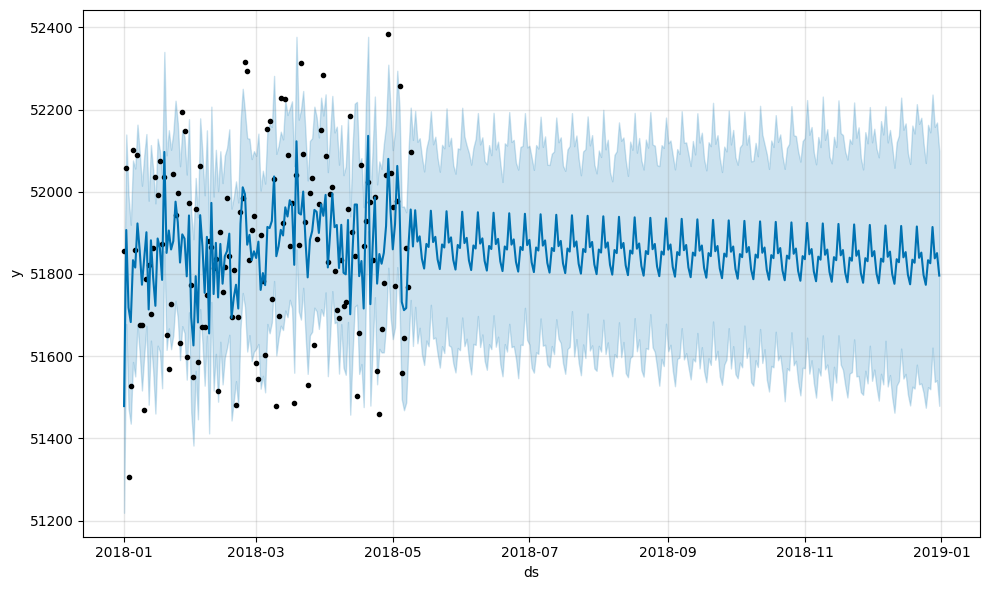

In [12]:
# create Prophet's Model
m_daily_order = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_daily_prophet_order['ds'].max())
end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_days = (end_of_year - last_date).days

# Add variable discount as additional regressor
m_daily_order.add_regressor('total_discount')

# Fit model to the data
m_daily_order.fit(df_daily_prophet_order)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_daily_order = m_daily_order.make_future_dataframe(periods= forecast_days)

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_daily_prophet_order['ds'] = pd.to_datetime(df_daily_prophet_order['ds'])
future_daily_order['ds'] = pd.to_datetime(future_daily_order['ds'])

future_daily_order = future_daily_order.merge(
    df_daily_prophet_order[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_daily_prophet_order['total_discount'].mean()
future_daily_order['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_daily_order = m_daily_order.predict(future_daily_order)

# Show the prediction result for few last rows
print(future_daily_order[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m_daily_order.plot(future_daily_order)
fig.show()



### Forecasting - Daily - Order Evaluation Model

In [20]:
# Parse data to have same data type
df_daily_prophet_order['ds'] = pd.to_datetime(df_daily_prophet_order['ds'])
future_daily_order['ds'] = pd.to_datetime(future_daily_order['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_daily_order = df_daily_prophet_order.merge(future_daily_order[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_daily_order_eval = df_merged_daily_order[df_merged_daily_order['yhat'].notnull()]

# Calculate MAE
mae_daily_order = mean_absolute_error(df_daily_order_eval['y'], df_daily_order_eval['yhat'])
print(f'MAE: {mae_daily_order:.2f}')

# Calculate MAPE
mape_daily_revenue = np.mean(np.abs((df_daily_order_eval['y'] - df_daily_order_eval['yhat']) / df_daily_order_eval['y'])) * 100
print(f'MAPE: {mape_daily_revenue:.2f}%')


MAE: 153.51
MAPE: 0.30%


In [14]:
# future_daily_order

### Forecasting - Daily - Revenue

In [16]:
# rename column to follow Prophet prerequisite
df_daily_prophet_revenue = df_daily.rename(columns = {'date_key':'ds','total_revenue':'y'} )

print(df_daily_prophet_revenue.head())

           ds  total_order            y  total_discount
0  2018-01-01        51856 2,640,588.96        1,504.70
1  2018-01-02        52059 2,639,210.97        1,572.00
2  2018-01-03        51306 2,610,001.02        1,535.00
3  2018-01-04        51527 2,617,471.57        1,530.90
4  2018-01-05        52101 2,643,557.21        1,540.20


16:10:08 - cmdstanpy - INFO - Chain [1] start processing
16:10:08 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yusuf\AppData\Local\Temp\ipykernel_17388\2204967798.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  future_daily_revenue['total_discount'].fillna(avg_discount, inplace=True)
C:\Users\yusuf\AppData\Local\Temp\ipykernel_17388\2204967798.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


            ds         yhat   yhat_lower   yhat_upper
360 2018-12-27 2,655,882.77 2,619,309.97 2,693,500.68
361 2018-12-28 2,661,630.80 2,624,992.27 2,702,129.70
362 2018-12-29 2,657,722.01 2,621,421.67 2,693,991.08
363 2018-12-30 2,660,391.92 2,622,781.38 2,698,420.06
364 2018-12-31 2,656,784.03 2,619,856.24 2,695,148.98


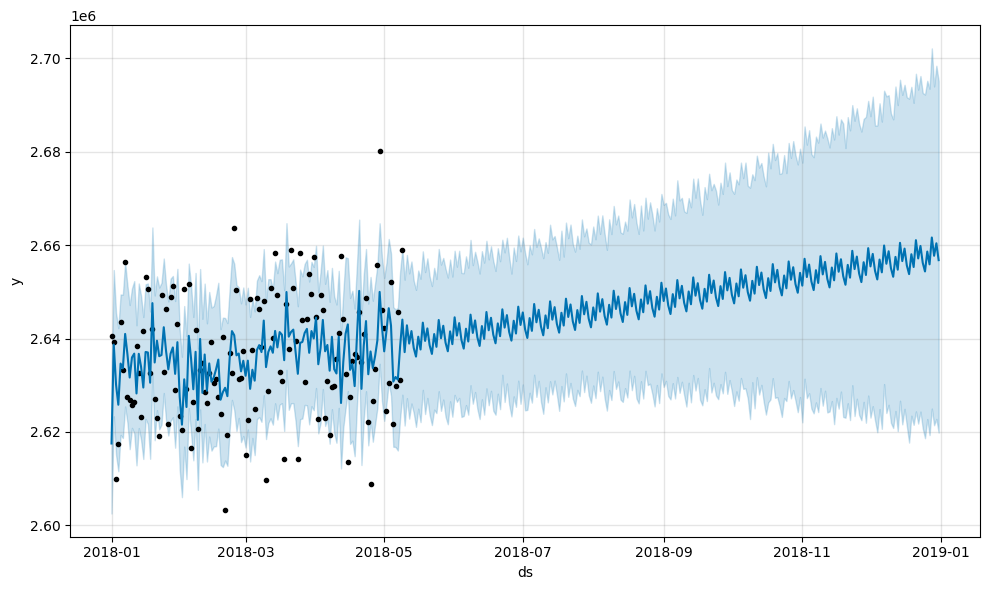

In [17]:
# create Prophet's Model
m_daily_revenue = Prophet()

# Calculate the period to perform forecasting up to end of year
last_date = pd.to_datetime(df_daily_prophet_revenue['ds'].max())
end_of_year = pd.Timestamp(year=last_date.year,month=12,day=31)
forecast_days = (end_of_year - last_date).days

# Add variable discount as additional regressor
m_daily_revenue.add_regressor('total_discount')

# Fit model to the data
m_daily_revenue.fit(df_daily_prophet_revenue)

# Create a dataframe for predicted period in future (e.g 90 day onwards)
future_daily_revenue = m_daily_revenue.make_future_dataframe(periods= forecast_days)

# Merge historical additional regressor (discount amount) from training to future dataframe based on 'ds'
df_daily_prophet_revenue['ds'] = pd.to_datetime(df_daily_prophet_revenue['ds'])
future_daily_revenue['ds'] = pd.to_datetime(future_daily_revenue['ds'])

future_daily_revenue = future_daily_revenue.merge(
    df_daily_prophet_revenue[['ds', 'total_discount']],
    on='ds',
    how='left'
)

# In the future data, the data without discount data will be filled as 0
avg_discount = df_daily_prophet_revenue['total_discount'].mean()
future_daily_revenue['total_discount'].fillna(avg_discount, inplace=True)

# Forecasting
future_daily_revenue = m_daily_revenue.predict(future_daily_revenue)

# Show the prediction result for few last rows
print(future_daily_revenue[['ds','yhat','yhat_lower','yhat_upper']].tail())

# Visualize the predicted result
fig = m_daily_revenue.plot(future_daily_revenue)
fig.show()



### Forecasting - Daily - Revenue Evaluation Model

In [19]:
# Parse data to have same data type
df_daily_prophet_revenue['ds'] = pd.to_datetime(df_daily_prophet_revenue['ds'])
future_daily_revenue['ds'] = pd.to_datetime(future_daily_revenue['ds'])

# Merge data origin with prediction based on data granurality key
df_merged_daily_revenue = df_daily_prophet_revenue.merge(future_daily_revenue[['ds','yhat']], on='ds', how='left')

# Only data from origin and prediction that will be included (excluding data for future)
df_daily_revenue_eval = df_merged_daily_revenue[df_merged_daily_revenue['yhat'].notnull()]

# Calculate MAE
mae_daily_revenue = mean_absolute_error(df_daily_revenue_eval['y'], df_daily_revenue_eval['yhat'])
print(f'MAE Daily Revenue: {mae_daily_revenue:.2f}')

# Calculate MAPE
mape_daily_revenue = np.mean(np.abs((df_daily_revenue_eval['y'] - df_daily_revenue_eval['yhat']) / df_daily_revenue_eval['y'])) * 100
print(f'MAPE Daily Revenue: {mape:.2f}%')


MAE Daily Revenue: 9599.97
MAPE Daily Revenue: 0.30%


### Forecasting - Daily - Order & Revenue

In [38]:
# Data forecasting Order
data_export_daily_order = future_daily_order[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
# print(data_export_daily_order.tail())

# Data forecasting Revenue
data_export_daily_revenue = future_daily_revenue[['ds','yhat','yhat_lower','yhat_upper','trend','trend_lower','trend_upper']]
# print(data_export_daily_revenue.tail())

# Rename 'ds' to 'date_key'
data_export_daily_order = data_export_daily_order.rename(columns={'ds': 'period_key'})
data_export_daily_revenue = data_export_daily_revenue.rename(columns={'ds': 'period_key'})

# Adding prefix to each column aside 'date_key' column
order_cols = [col for col in data_export_daily_order.columns if col != 'period_key']
data_export_daily_order = data_export_daily_order.rename(columns={col: 'order_' + col for col in order_cols})

revenue_cols = [col for col in data_export_daily_revenue.columns if col != 'period_key']
data_export_daily_revenue = data_export_daily_revenue.rename(columns={col: 'revenue_' + col for col in revenue_cols})

# Convert date_key have datetime data_type
data_export_daily_order['period_key'] = pd.to_datetime(data_export_daily_order['period_key'])
data_export_daily_revenue['period_key'] = pd.to_datetime(data_export_daily_revenue['period_key'])

# Combined daily forecast order and forecast revenue
data_export_forecast_daily = pd.merge(data_export_daily_order, data_export_daily_revenue, on='period_key', how='outer')

# Add additional column for data labeling period
data_export_forecast_daily['forecast_granularity'] = 'forecast_daily'
data_export_forecast_daily['model_used'] = 'prophet'

# Check the result
print(data_export_forecast_daily.tail())


    period_key  order_yhat  order_yhat_lower  order_yhat_upper  order_trend  \
360 2018-12-27   51,826.04         51,519.57         52,144.63    51,833.34   
361 2018-12-28   51,914.27         51,620.80         52,236.54    51,833.16   
362 2018-12-29   51,837.95         51,537.39         52,157.93    51,832.99   
363 2018-12-30   51,850.74         51,541.25         52,168.50    51,832.81   
364 2018-12-31   51,796.05         51,479.14         52,098.88    51,832.63   

     order_trend_lower  order_trend_upper  revenue_yhat  revenue_yhat_lower  \
360          51,636.06          52,034.30  2,655,882.77        2,619,309.97   
361          51,634.42          52,035.88  2,661,630.80        2,624,992.27   
362          51,633.47          52,037.58  2,657,722.01        2,621,421.67   
363          51,632.58          52,038.68  2,660,391.92        2,622,781.38   
364          51,631.68          52,039.80  2,656,784.03        2,619,856.24   

     revenue_yhat_upper  revenue_trend  revenue_tr

### Push Data to Database

In [39]:
# Table target
table_name = 'ct_groceries_forecast_result'

# Push data to MySQL
data_export_forecast_daily.to_sql (
    name=table_name, 
    con=engine,
    if_exists='replace',
    index=False
)
print("Data has been sucessfully push to database:", table_name)

Data has been sucessfully push to database: ct_groceries_forecast_result
